## Import necessary libraries


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, UpSampling2D, Dropout

### Load our data

Here, we are using MNIST dataset


In [2]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
# to get the shape of the data
print("x_train shape:", x_train.shape)
print("x_test shape", x_test.shape)

11493376/11490434 [==============================] - 0s 0us/step
x_train shape: (60000, 28, 28)
x_test shape (10000, 28, 28)


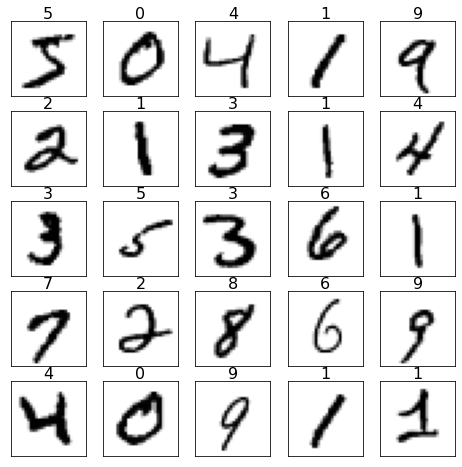

In [3]:
plt.figure(figsize=(8, 8))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.title(str(y_train[i]), fontsize=16, color="black", pad=2)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    plt.xticks([])
    plt.yticks([])

plt.show()

## Spliting test data for validation and testing


In [4]:
val_images = x_test[:9000]
test_images = x_test[9000:]

## Normalizing and reshaping


In [5]:
val_images = val_images.astype("float32") / 255.0
val_images = np.reshape(val_images, (val_images.shape[0], 28, 28, 1))

test_images = test_images.astype("float32") / 255.0
test_images = np.reshape(test_images, (test_images.shape[0], 28, 28, 1))

train_images = x_train.astype("float32") / 255.0
train_images = np.reshape(train_images, (train_images.shape[0], 28, 28, 1))

## Adding noise


In [6]:
factor = 0.39
train_noisy_images = train_images + factor * np.random.normal(
    loc=0.0, scale=1.0, size=train_images.shape
)
val_noisy_images = val_images + factor * np.random.normal(
    loc=0.0, scale=1.0, size=val_images.shape
)
test_noisy_images = test_images + factor * np.random.normal(
    loc=0.0, scale=1.0, size=test_images.shape
)

# here maximum pixel value for our images may exceed 1 so we have to clip the images
train_noisy_images = np.clip(train_noisy_images, 0.0, 1.0)
val_noisy_images = np.clip(val_noisy_images, 0.0, 1.0)
test_noisy_images = np.clip(test_noisy_images, 0.0, 1.0)

## Visualizing images after adding noise


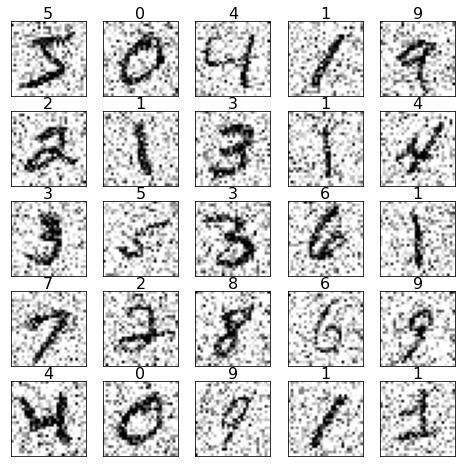

In [7]:
plt.figure(figsize=(8, 8))

for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.title(str(y_train[i]), fontsize=16, color="black", pad=2)
    plt.imshow(train_noisy_images[i].reshape(1, 28, 28)[0], cmap=plt.cm.binary)
    plt.xticks([])
    plt.yticks([])

plt.show()

## Defining our autoencoder model


In [8]:
model = Sequential()
# encoder network
model.add(
    Conv2D(
        filters=128,
        kernel_size=(2, 2),
        activation="relu",
        padding="same",
        input_shape=(28, 28, 1),
    )
)
model.add(tf.keras.layers.BatchNormalization())
model.add(Conv2D(filters=128, kernel_size=(2, 2), activation="relu", padding="same"))
model.add(tf.keras.layers.BatchNormalization())
model.add(
    Conv2D(
        filters=256,
        kernel_size=(2, 2),
        strides=(2, 2),
        activation="relu",
        padding="same",
    )
)
model.add(tf.keras.layers.BatchNormalization())
model.add(Conv2D(filters=256, kernel_size=(2, 2), activation="relu", padding="same"))
model.add(tf.keras.layers.BatchNormalization())
model.add(Conv2D(filters=512, kernel_size=(3, 3), activation="relu", padding="same"))
model.add(tf.keras.layers.BatchNormalization())
model.add(
    Conv2D(
        filters=512,
        kernel_size=(2, 2),
        strides=(2, 2),
        activation="relu",
        padding="same",
    )
)


# decoder network
model.add(Conv2D(filters=512, kernel_size=(2, 2), activation="relu", padding="same"))

model.add(
    tf.keras.layers.Conv2DTranspose(
        filters=512,
        kernel_size=(2, 2),
        strides=(2, 2),
        activation="relu",
        padding="same",
    )
)
model.add(tf.keras.layers.BatchNormalization())
model.add(Conv2D(filters=256, kernel_size=(2, 2), activation="relu", padding="same"))
model.add(tf.keras.layers.BatchNormalization())
model.add(Conv2D(filters=256, kernel_size=(2, 2), activation="relu", padding="same"))
model.add(tf.keras.layers.BatchNormalization())
model.add(Conv2D(filters=128, kernel_size=(2, 2), activation="relu", padding="same"))


model.add(
    tf.keras.layers.Conv2DTranspose(
        filters=128,
        kernel_size=(2, 2),
        strides=(2, 2),
        activation="relu",
        padding="same",
    )
)
model.add(Conv2D(filters=64, kernel_size=(2, 2), activation="relu", padding="same"))
model.add(tf.keras.layers.BatchNormalization())

model.add(Conv2D(filters=1, kernel_size=(2, 2), activation="relu", padding="same"))


# to get the summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 128)       640       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 128)       512       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 128)       65664     
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 128)       512       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 256)       131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 14, 14, 256)       1024      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 256)       2

# Compile model


In [9]:
OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=0.001)
LOSS = "mean_squared_error"
model.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=["accuracy"])

# Fitting the model


In [10]:
EPOCHS = 5
BATCH_SIZE = 256
VALIDATION = (val_noisy_images, val_images)
history = model.fit(
    train_noisy_images,
    train_images,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=VALIDATION,
)

Epoch 1/5
235/235 [==============================] - 94s 400ms/step - loss: 0.0732 - accuracy: 0.7996 - val_loss: 0.1120 - val_accuracy: 0.8079
Epoch 2/5
235/235 [==============================] - 107s 455ms/step - loss: 0.0102 - accuracy: 0.8140 - val_loss: 0.0517 - val_accuracy: 0.8111
Epoch 3/5
235/235 [==============================] - 106s 450ms/step - loss: 0.0086 - accuracy: 0.8144 - val_loss: 0.0097 - val_accuracy: 0.8145
Epoch 4/5
235/235 [==============================] - 107s 454ms/step - loss: 0.0080 - accuracy: 0.8145 - val_loss: 0.0081 - val_accuracy: 0.8144
Epoch 5/5
235/235 [==============================] - 107s 455ms/step - loss: 0.0076 - accuracy: 0.8146 - val_loss: 0.0077 - val_accuracy: 0.8145


### Model evaluation

loss and accuracy curve


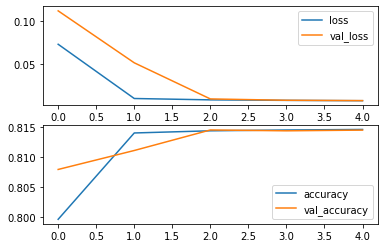

In [11]:
plt.subplot(2, 1, 1)
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.legend(loc="best")
plt.subplot(2, 1, 2)
plt.plot(history.history["accuracy"], label="accuracy")
plt.plot(history.history["val_accuracy"], label="val_accuracy")
plt.legend(loc="best")
plt.show()

## Visualizing our predicted images along with real and noised images


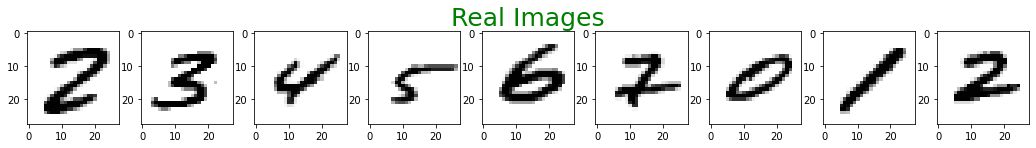

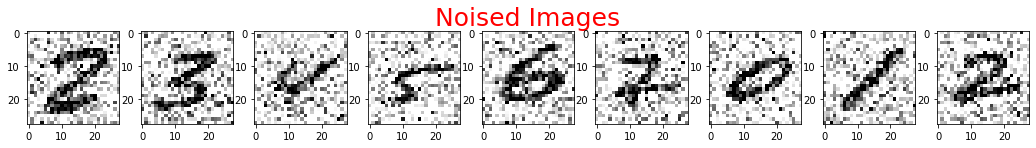

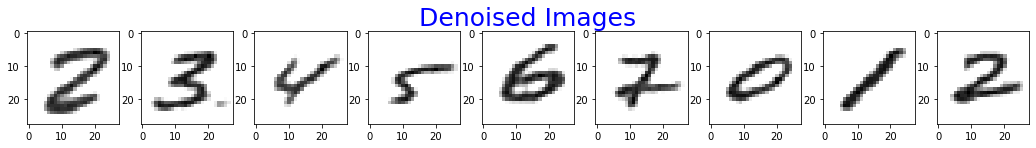

In [12]:
plt.figure(figsize=(18, 18))
for i in range(10, 19):
    plt.subplot(9, 9, i)
    if i == 14:
        plt.title("Real Images", fontsize=25, color="Green")
    plt.imshow(test_images[i].reshape(1, 28, 28)[0], cmap=plt.cm.binary)
plt.show()


plt.figure(figsize=(18, 18))
for i in range(10, 19):
    if i == 15:
        plt.title("Noised Images", fontsize=25, color="red")
    plt.subplot(9, 9, i)
    plt.imshow(test_noisy_images[i].reshape(1, 28, 28)[0], cmap=plt.cm.binary)
plt.show()


plt.figure(figsize=(18, 18))
for i in range(10, 19):
    if i == 15:
        plt.title("Denoised Images", fontsize=25, color="Blue")

    plt.subplot(9, 9, i)
    plt.imshow(
        model.predict(test_noisy_images[i].reshape(1, 28, 28, 1)).reshape(1, 28, 28)[0],
        cmap=plt.cm.binary,
    )
plt.show()